In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [2]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter


from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

import cx_spiking.optimisation.metric as metric
import cx_spiking.optimisation.ng_optimiser as ng_optimiser

In [76]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)
headings = np.concatenate((headings, np.zeros(headings.shape)), axis=0)


# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)
flow = np.concatenate((flow, np.zeros(flow.shape)), axis=0)

######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=0,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz
/Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz exists - not overwriting it


In [77]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [78]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')
SPM_H = SpikeMonitor(P_HEADING)

In [79]:
run((T_outbound+T_inbound)*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 60. s
33.4522 s (55%) simulated in 10s, estimated 8s remaining.
58.7787 s (97%) simulated in 20s, estimated < 1s remaining.
60. s (100%) simulated in 20s


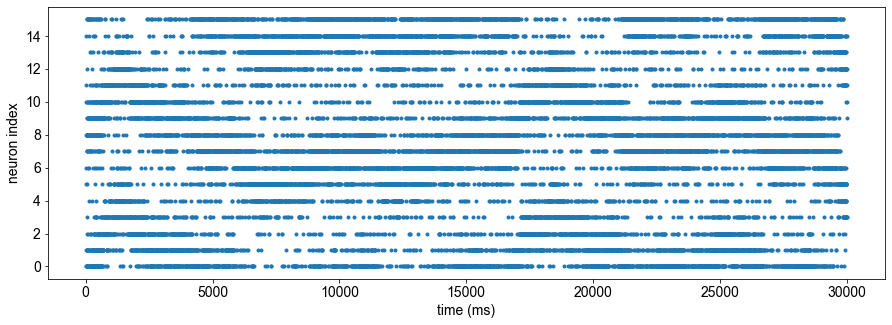

In [80]:
plt.figure(figsize=(15,5))
brian_plot(SPM_H)

# Extract heading during route

In [372]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [373]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')
SPM_H = SpikeMonitor(P_HEADING)

In [374]:
# Neuron groups already optimised
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, TL2_neuron_params, name='TL2_source_network')
G_CL1 = nc.generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, CL1_neuron_params, name='CL1_source_network')
G_TB1 = nc.generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, TB1_neuron_params, name='TB1_source_network')

# Synapses optimised
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, 
                                      params=H_TL2_synapses_params, on_pre=synapses_eqs_ex)
S_TL2_CL1 = nc.connect_synapses(G_TL2, G_CL1, W_TL2_CL1, model=synapses_model, 
                                params=TL2_CL1_synapses_params, on_pre=synapses_eqs_ex)
S_CL1_TB1 = nc.connect_synapses(G_CL1, G_TB1, W_CL1_TB1, model=synapses_model, 
                                params=CL1_TB1_synapses_params, on_pre=synapses_eqs_ex)
S_TB1_TB1 = nc.connect_synapses(G_TB1, G_TB1, W_TB1_TB1, model=synapses_model, 
                                params=TB1_TB1_synapses_params, on_pre=synapses_eqs_in)

SPM_TB1 = SpikeMonitor(G_TB1)

In [375]:
from scipy.stats import norm

global heading_angles
heading_angles = []

@network_operation(dt=time_step*ms)
def extract_heading(t):
    global heading_angles
    
    if t < time_step*ms:
        heading_angles.append(0)
        return
    spike_trains = SPM_TB1.spike_trains()
    neurons = np.zeros(len(SPM_TB1.spike_trains()))
    for idx in range(len(spike_trains)):
        spike_train = spike_trains[idx]
        neurons[idx] = len(spike_train[(spike_train > t-time_step*ms) & (spike_train < t)])

    mean,std=norm.fit(neurons)
    try:
        heading_angles.append(np.ma.average(np.arange(N_TB1), weights=neurons))
    except:
        heading_angles.append(0)
    #print(neurons, mean, std, np.ma.average(np.arange(N_TB1), weights=neurons))
    #print()
    
@network_operation(dt=time_step*ms)
def CPU4_accumulator(t):
    timestep = int((t/ms) / time_step)
    

In [376]:
run((T_outbound)*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 30. s
1.7041 s (5%) simulated in 10s, estimated 2m 46s remaining.
4.2565 s (14%) simulated in 20s, estimated 2m 1s remaining.
8.4101 s (28%) simulated in 30s, estimated 1m 17s remaining.
13.009 s (43%) simulated in 40s, estimated 52s remaining.
17.7522 s (59%) simulated in 50s, estimated 34s remaining.
22.504 s (75%) simulated in 1m 0s, estimated 20s remaining.
26.3945 s (87%) simulated in 1m 10s, estimated 10s remaining.
30. s (100%) simulated in 1m 18s


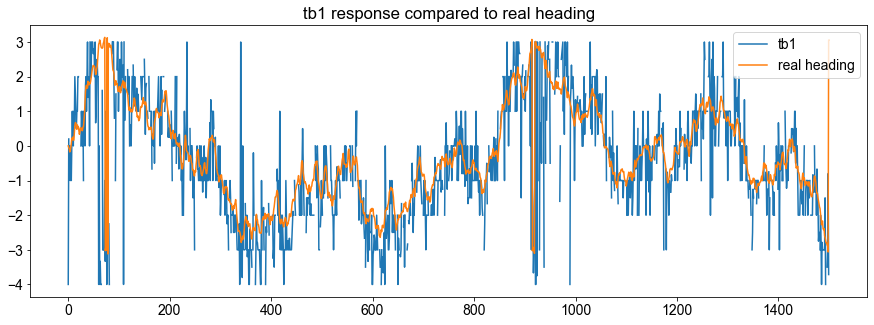

1500


In [382]:
def to_degrees(data):
    new_value = (data - 0) / (N_TB1 - 0) * (np.pi - (-np.pi)) 
    return new_value


plt.figure(figsize=(15,5))
plt.plot(np.array(heading_angles)-4, label='tb1')
plt.plot(h, label='real heading')
#plt.xlim([0,400])
plt.title('tb1 response compared to real heading')
plt.legend()
plt.show()

print(len(heading_angles))

TypeError: 'method' object is not subscriptable

In [96]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [97]:
motors = cx_spiking.inputs.compute_motors(cx_log.cpu1)
m2 = cx_spiking.inputs.normalise_range(motors)

h_motors = TimedArray(m2.T*Hz, dt=1.*time_step*ms)
P_MOTOR = PoissonGroup(N_MOTOR, rates='h_motors(t,i)')
SPM_MOTOR = SpikeMonitor(P_MOTOR)

In [98]:
run((T_outbound+T_inbound)*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 60. s
31.3714 s (52%) simulated in 10s, estimated 9s remaining.
60. s (100%) simulated in 18s


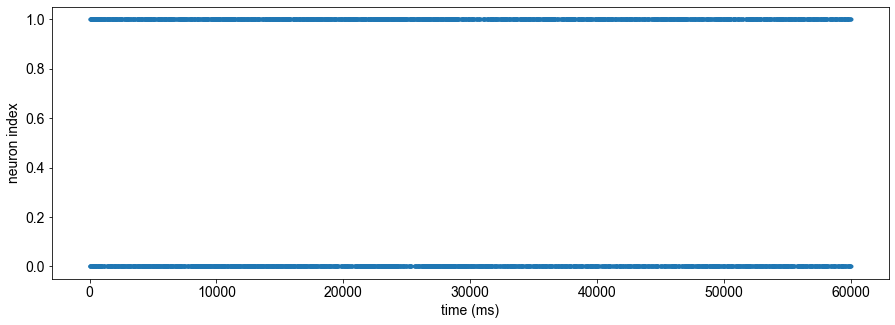

In [99]:
plt.figure(figsize=(15,5))
brian_plot(SPM_MOTOR)

In [100]:
motor_rates = cx_spiking.inputs.get_spikes_rates(SPM_MOTOR, N_MOTOR, T_outbound+T_inbound, time_step)

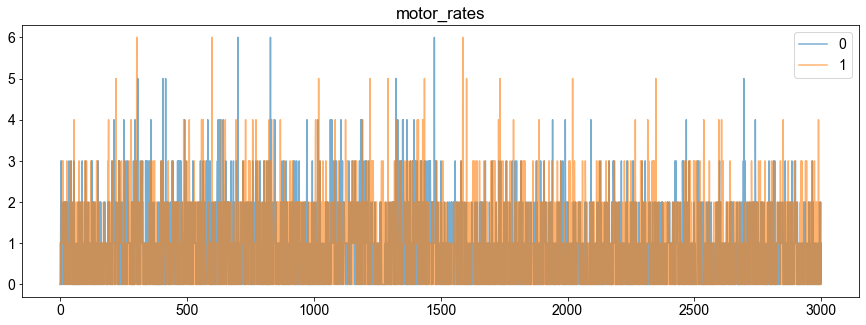

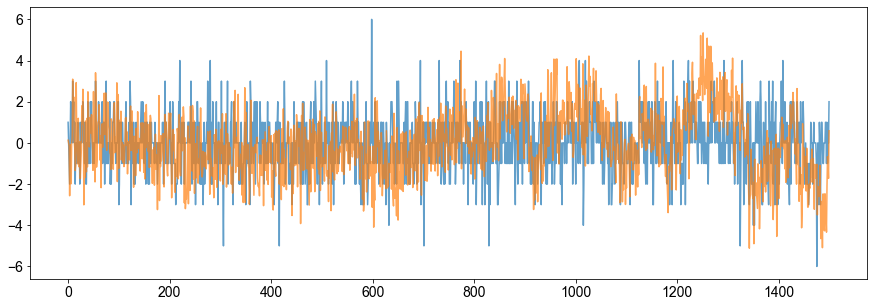

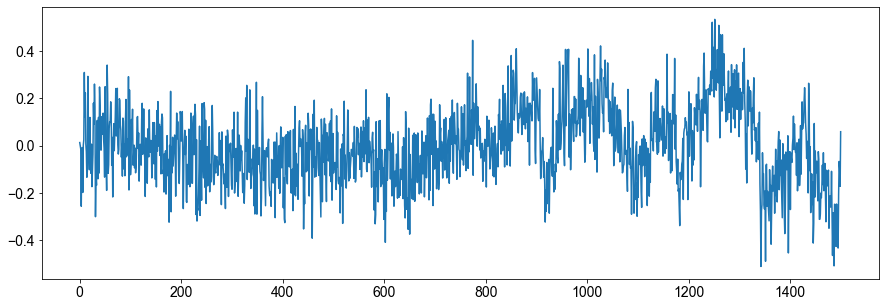

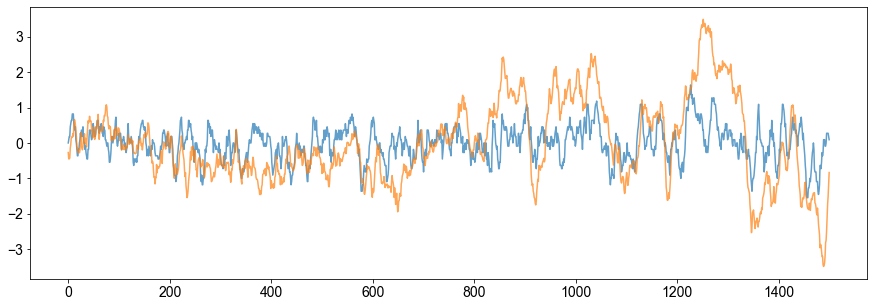

In [113]:
plt.figure(figsize=(15,5))
plt.title('motor_rates')
for idx, r in enumerate(motor_rates):
    plt.plot(r, alpha=0.6, label=idx)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(motor_rates[1, :T_outbound] - motor_rates[0, :T_outbound], alpha=0.7, label='spiking')
plt.plot(cx_log.motor*10, alpha=0.7, label='rate')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(cx_log.motor)
plt.show()

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(15,5))
plt.plot(smooth(motor_rates[1, :T_outbound] - motor_rates[0, :T_outbound], 11), alpha=0.7, label='spiking')
plt.plot(smooth(cx_log.motor*10, 11), alpha=0.7, label='rate')
plt.show()



[5.35000e+01 6.60000e+01 6.91000e+01 ... 5.99510e+04 5.99542e+04
 5.99805e+04]


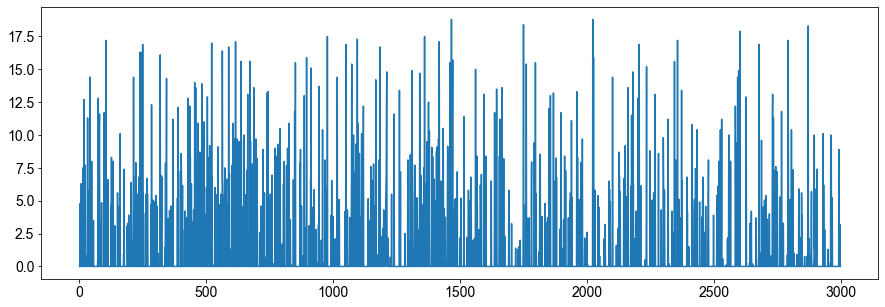

[1.77000e+01 6.93000e+01 1.11100e+02 ... 5.99403e+04 5.99555e+04
 5.99847e+04]


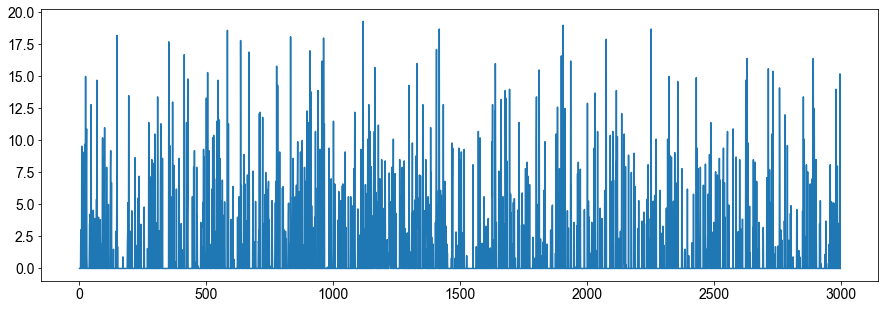

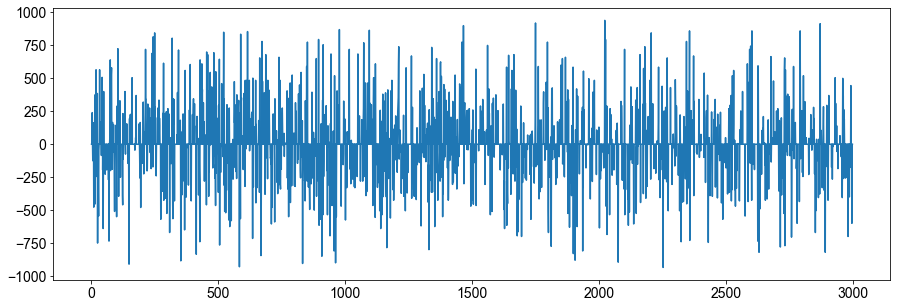

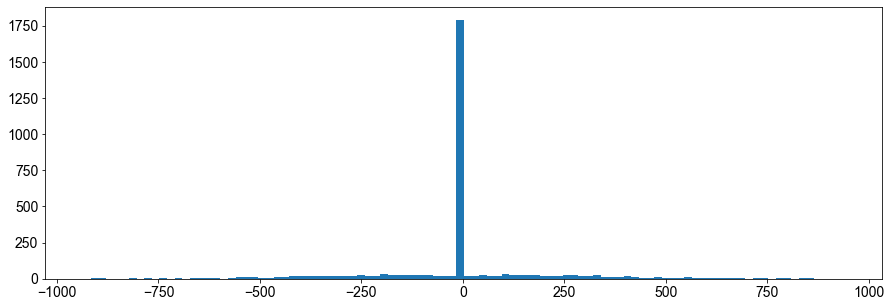

In [141]:
# compute ISI of each time_step window
spikes_t = SPM_MOTOR.t/ms
spikes_i = SPM_MOTOR.i

spikes_out = np.zeros((N_MOTOR, T_outbound+T_inbound))
bins = np.arange(0, (T_outbound+T_inbound+1)*time_step, time_step)

isi = np.zeros((N_MOTOR, T_outbound+T_inbound))
for i in range(N_MOTOR):
    spikes = spikes_t[spikes_i == i]
    print(spikes)
    for ts in range(T_outbound+T_inbound):
        idxs = np.where(np.logical_and(spikes > ts*time_step, spikes<= (ts+1)*time_step))
        spikes_to_consider = spikes[idxs]
        if len(spikes_to_consider) > 1:
            diffs = np.diff(spikes_to_consider)
            #print(ts, spikes_to_consider, diffs, np.mean(diffs))
        #spikes_count, _ = np.histogram(spikes, bins=bins)
        #spikes_out[i,:] = spikes_count
            isi[i, ts] = np.mean(diffs)
    plt.figure(figsize=(15,5))
    plt.plot(isi[i])
    plt.show()
    
plt.figure(figsize=(15,5))
plt.plot((isi[0]-isi[1])* 1000/time_step) 
plt.show()

plt.figure(figsize=(15,5))
plt.hist((isi[0]-isi[1])* 1000/time_step, bins=100)
plt.show()